In [79]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np


In [80]:
# Load data
#parsing date and setting the 'date' column as the index
#resampling data to daily frequency 

df = pd.read_csv("data-train.csv", parse_dates=["date"], index_col = "date").asfreq("D")
df

,orders,temperature,media_spend
date,,,
2020-05-02,54,18.270322,0.0
2020-05-03,63,19.882444,0.0
2020-05-04,56,16.878095,0.0
2020-05-05,65,21.878648,0.0
2020-05-06,64,21.112398,0.0
...,...,...,...
2022-06-12,76,11.472592,0.0
2022-06-13,78,NaN,0.0
2022-06-14,79,11.813969,0.0


In [81]:
# same to do unseen data
unseen = pd.read_csv("data-unseen-features.csv", parse_dates=["date"], index_col = "date").asfreq("D")
unseen

,temperature,media_spend
date,,
2022-06-17,11.923126,0.000000
2022-06-18,14.986238,0.000000
2022-06-19,11.003947,0.000000
2022-06-20,12.699259,0.000000
2022-06-21,17.852300,0.000000
2022-06-22,11.601299,0.000000
2022-06-23,16.207998,14.847883
2022-06-24,12.952067,0.000000
2022-06-25,9.284319,14.664207


In [82]:
# Looking data shape
df.shape, unseen.shape

((776, 3), (14, 2))

In [83]:
corr_df =df[['temperature', 'media_spend', 'orders']].corr(method='spearman')
corr_unseen = unseen[['temperature', 'media_spend']].corr(method='spearman')
print('train data correlation:','\n',corr_df)
print('train data correlation:','\n',corr_unseen)


train data correlation: 
              temperature  media_spend    orders
temperature     1.000000     0.023737  0.715629
media_spend     0.023737     1.000000  0.199126
orders          0.715629     0.199126  1.000000
train data correlation: 
              temperature  media_spend
temperature     1.000000    -0.069886
media_spend    -0.069886     1.000000


There is a moderately strong positive correlation (0.716) between temperature and orders, indicating that as temperature increases, the number of orders tends to increase.

In [84]:
# Check for missing values
df.isnull().sum()

orders          0
temperature    20
media_spend     0
dtype: int64

In [85]:
unseen.isnull().sum()

temperature    1
media_spend    0
dtype: int64

In [86]:
#interpolating missing values
df['temperature'] = df['temperature'].interpolate()
unseen['temperature'] = unseen['temperature'].interpolate()

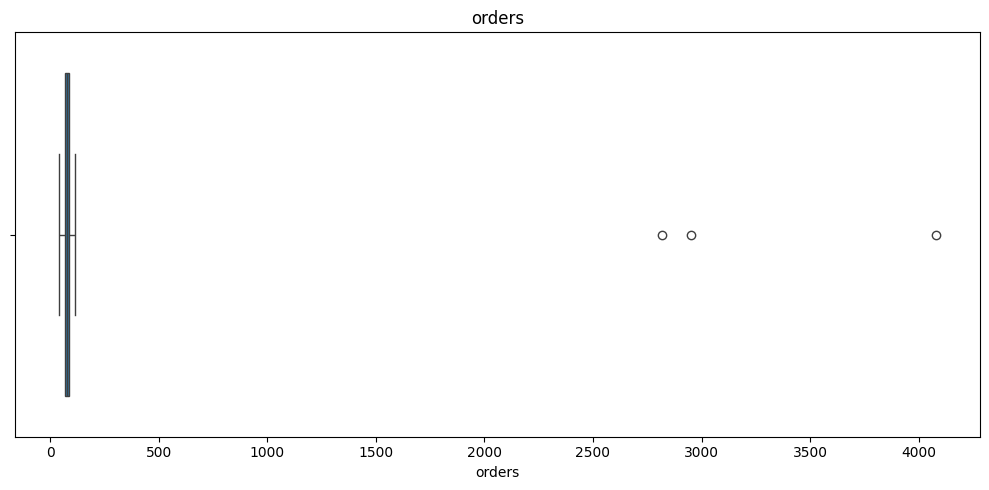

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 5)

sns.boxplot(x=df["orders"])
plt.title("orders")
plt.tight_layout()
plt.show()


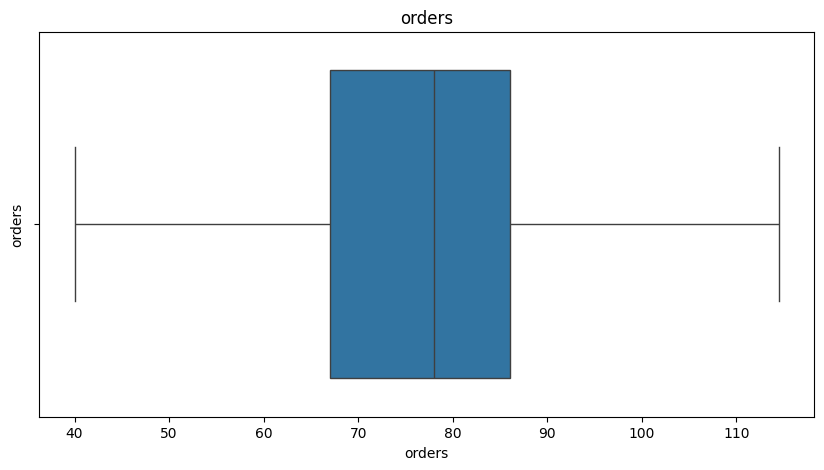

In [88]:

# Determine lower and upper bounds for the "orders" column
q1 = df['orders'].quantile(0.25)
q3 = df['orders'].quantile(0.75)
IQR = q3 - q1
lower_limit = q1 - 1.5 * IQR
upper_limit = q3 + 1.5 * IQR

# Replace values lower than the lower bound with the lower bound
df['orders'] = df['orders'].apply(lambda x: lower_limit if x < lower_limit else x)

# Replace values higher than the upper bound with the upper bound
df['orders'] = df['orders'].apply(lambda x: upper_limit if x > upper_limit else x)

# Create a boxplot for the "orders" feature
sns.boxplot(df['orders'], orient='h')
plt.ylabel('orders')
plt.title('orders')
plt.show()



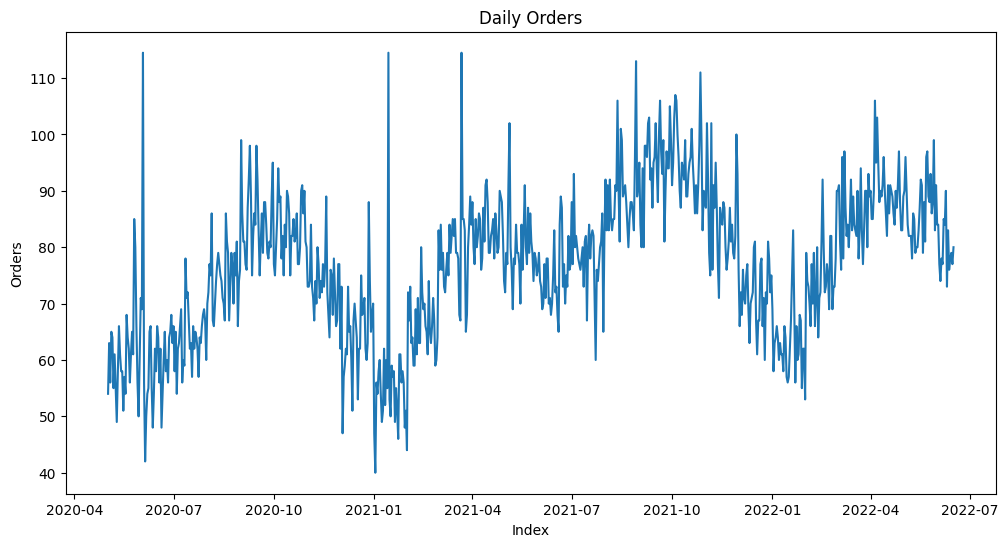

In [89]:
# Set the size of the figure
plt.figure(figsize=(12, 6))

# Plot the 'orders' column from the DataFrame
plt.plot(df['orders'])

# Label the x-axis, y-axis
plt.xlabel('Index')
plt.ylabel('Orders')

# Set the title of the plot
plt.title('Daily Orders')

# Display the plot
plt.show()



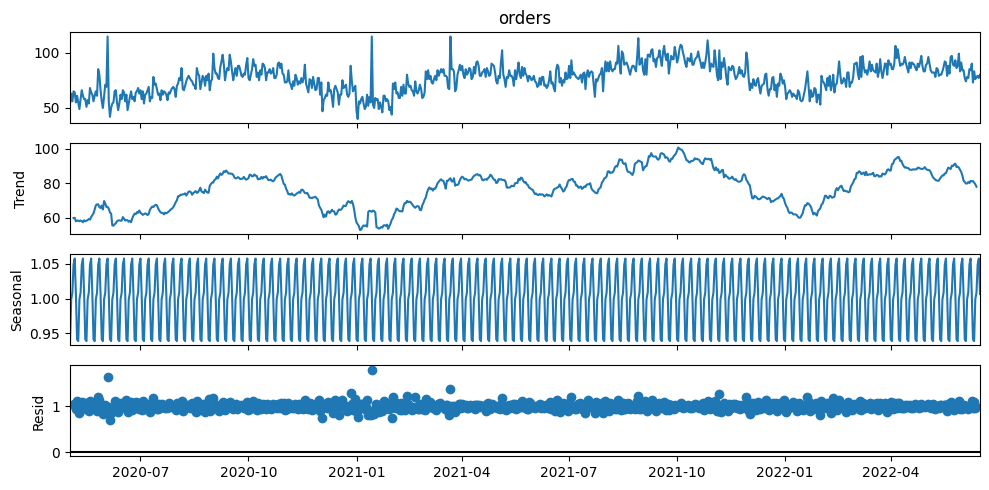

In [90]:
dec_df = seasonal_decompose(df.orders, model="mul", period=7).plot()

In [91]:
from statsmodels.tsa.stattools import adfuller
adf = adfuller(df["orders"])
print(adf[1])

0.09704356291982746


In this case, the p-value returned is approximately 0.097, which is greater than the commonly used significance level of 0.05.
Interpreting the result:
If the p-value is less than the significance level (commonly chosen as 0.05), then we reject the null hypothesis (the data has a unit root, indicating non-stationarity), and the data is considered stationary.
If the p-value is greater than the significance level, we fail to reject the null hypothesis, meaning there is insufficient evidence to conclude that the data is stationary. (Bu durumda, yaklaşık olarak 0.097 olan p-değeri kullanılmıştır, bu değer genellikle 0.05 olarak belirlenen yaygın anlamlılık düzeyinden daha büyüktür.
Sonucun yorumu:
P-değeri, anlamlılık düzeyinden (genellikle 0.05 olarak seçilir) daha küçükse, null hipotezi reddederiz (verinin bir birim kökü olduğu, yani durağan olmadığı anlamına gelir) ve veri durağan olarak kabul edilir.
P-değeri, anlamlılık düzeyinden büyükse, null hipotezini reddedemeyiz, bu da verinin durağan olduğuna dair yeterli kanıt olmadığı anlamına gelir.)

In [92]:
# Making the data stationary by taking the first difference
df1 = df.diff().dropna()

# Applying ADF test again
adf_test = adfuller(df1["orders"])
p_value = adf_test[1]

# Printing the p-value
print(p_value)


3.580446372152211e-13


it's a very small value. So, the result suggests that the "orders" data becomes stationary after taking the first difference.

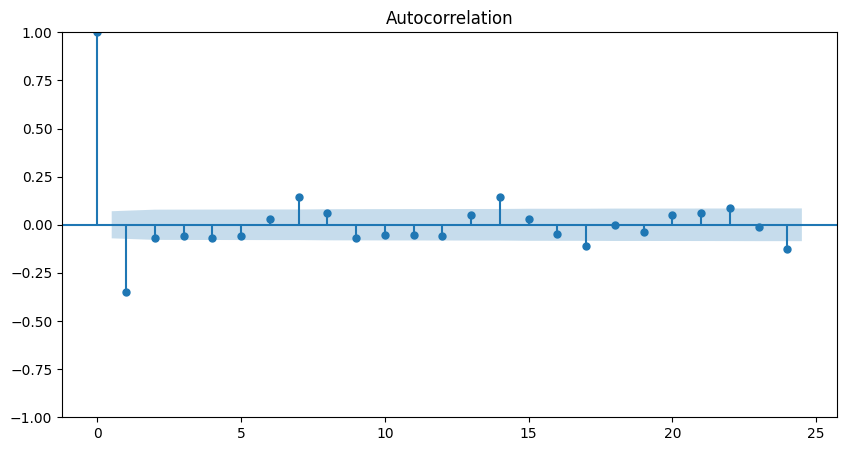

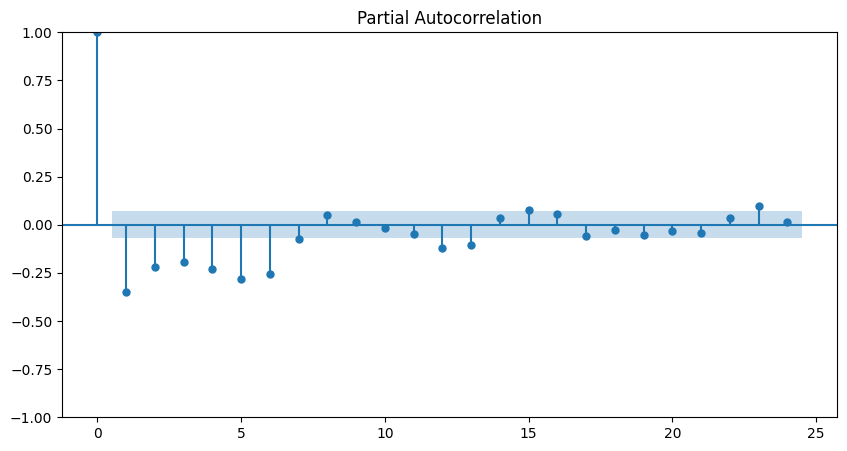

In [93]:
fig = plot_acf(df1["orders"], lags=24)
fig = plot_pacf(df1["orders"], lags=24)

In [94]:
train, test = df[:-14], df[-14:]
print(train)
print(test)

            orders  temperature  media_spend
date                                        
2020-05-02    54.0    18.270322          0.0
2020-05-03    63.0    19.882444          0.0
2020-05-04    56.0    16.878095          0.0
2020-05-05    65.0    21.878648          0.0
2020-05-06    64.0    21.112398          0.0
...            ...          ...          ...
2022-05-29    99.0    27.259745          0.0
2022-05-30    83.0    15.389206          0.0
2022-05-31    91.0    18.351899          0.0
2022-06-01    84.0    10.141080          0.0
2022-06-02    84.0    12.854688          0.0

[762 rows x 3 columns]
            orders  temperature  media_spend
date                                        
2022-06-03    77.0    14.021126          0.0
2022-06-04    74.0     8.557476          0.0
2022-06-05    78.0    12.326819          0.0
2022-06-06    77.0    14.085052          0.0
2022-06-07    85.0     9.062854          0.0
2022-06-08    84.0    11.424545          0.0
2022-06-09    90.0    19.228510

In [95]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

order_aic_bic = []
#train = # Eğitim verisini burada tanımlayın

for p in range(0, 2):
    for q in range(0, 2):
        for P in range(0, 2):
            for Q in range(0, 2):
                for d in range(0, 2):
                    for D in range(0, 2):
                        for trend in ["t", "n", "c", "ct"]:
                            model = SARIMAX(train["orders"], order=(p, d, q), seasonal_order=(P, D, Q, 7), trend=trend)
                            model_fit = model.fit()
                            aic = model_fit.aic
                            bic = model_fit.bic
                            order_aic_bic.append((p, d, q, P, D, Q, trend, aic, bic))
                
order_df = pd.DataFrame(order_aic_bic, columns=["p", "d", "q", "P", "D", "Q", "trend", "AIC", "BIC"])
print(order_df.sort_values("AIC").head(3))
print(order_df.sort_values("BIC").head(3))

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non

     p  d  q  P  D  Q trend          AIC          BIC
161  1  0  0  1  0  0     n  2434.629887  2448.537726
221  1  1  1  0  1  1     n  5103.696869  5122.198439
253  1  1  1  1  1  1     n  5104.714848  5127.841809
     p  d  q  P  D  Q trend          AIC          BIC
161  1  0  0  1  0  0     n  2434.629887  2448.537726
93   0  1  1  0  1  1     n  5106.333114  5120.209291
221  1  1  1  0  1  1     n  5103.696869  5122.198439


Best model:  ARIMA(1,1,1)(4,1,0)[7]
Best model:  ARIMA(4,2,0)(4,2,0)[7]
Best model:  ARIMA(1,1,1)(0,0,4)[7]    

In [96]:

model = SARIMAX(train["orders"], order=(0,1,1), seasonal_order=(0,1,1,7), trend="n")

# Modeli eğit              
model_fit = model.fit()

# Tahminleri yap
fitted = model_fit.predict()

# hata payını al
resids = model_fit.resid

# tahminleri train içine ekleyin

train.loc[:,"fitted"] = fitted

C:\Users\DELL\AppData\Local\Temp\ipykernel_24856\2718426132.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[:,"fitted"] = fitted


In [97]:
print(model_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                            orders   No. Observations:                  762
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 7)   Log Likelihood               -2550.167
Date:                           Sun, 11 Feb 2024   AIC                           5106.333
Time:                                   23:33:56   BIC                           5120.209
Sample:                               05-02-2020   HQIC                          5111.679
                                    - 06-02-2022                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7778      0.025    -31.466      0.000      -0.826      -0.729
ma.S.L7       -0.9717      0.016    -61.928

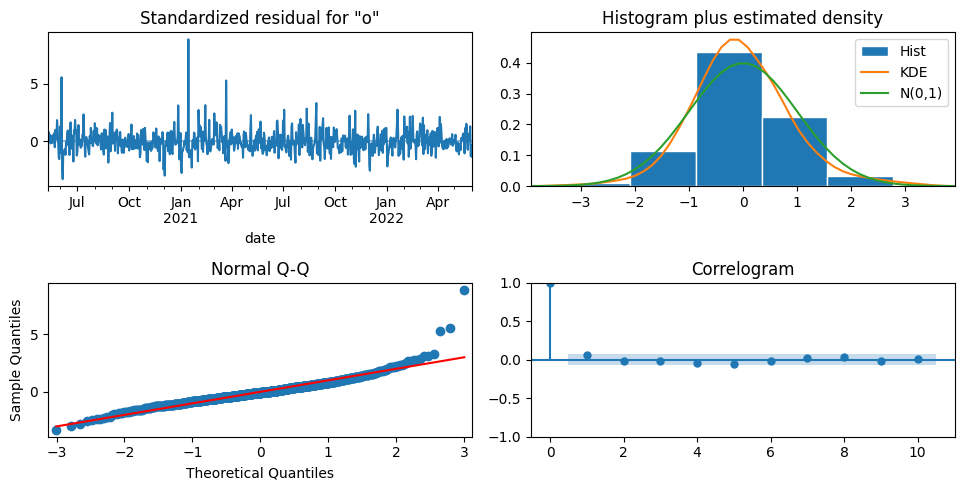

In [98]:
diags = model_fit.plot_diagnostics()
plt.tight_layout()
plt.show()

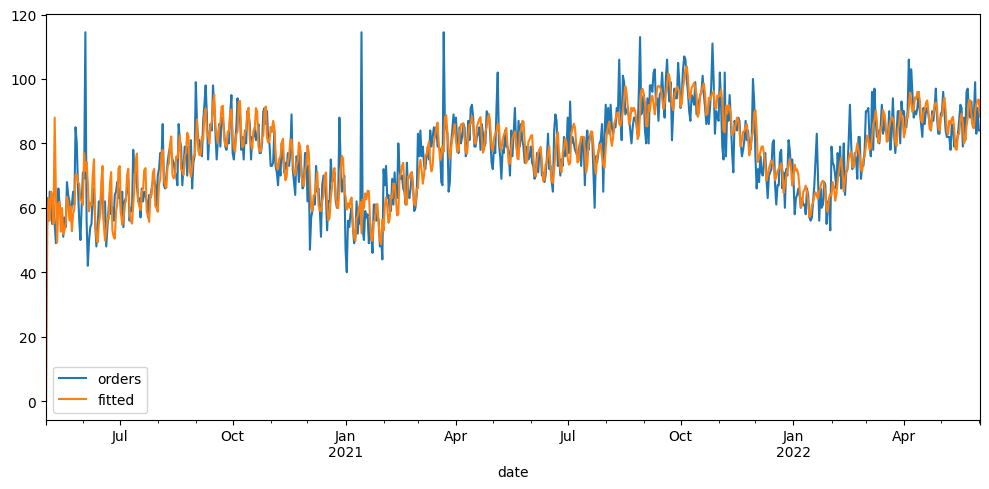

In [99]:
train[["orders","fitted"]].plot()
plt.tight_layout()
plt.show()

for test data

In [100]:
test_predicted = model_fit.forecast(steps=len(test), index=test.index)

C:\Users\DELL\AppData\Local\Temp\ipykernel_24856\1059522002.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:,"fitted"] = test_predicted


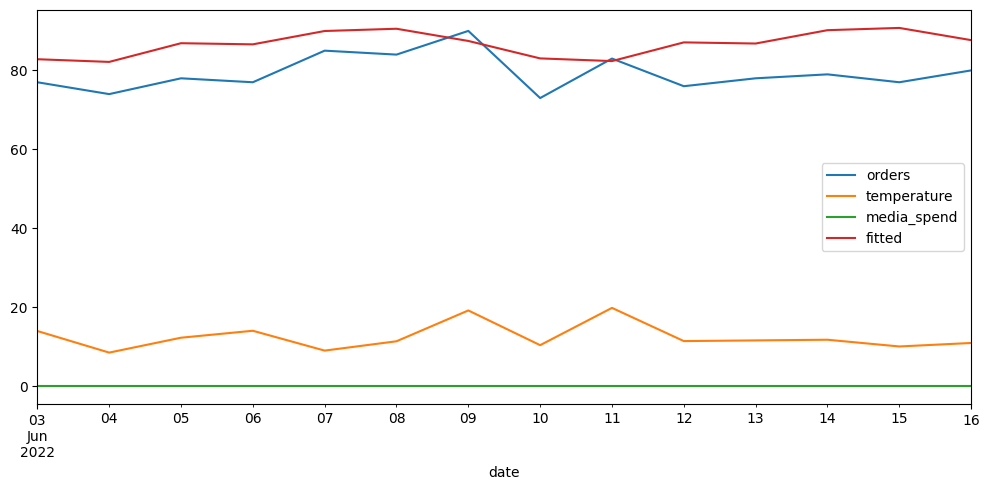

In [101]:
test.loc[:,"fitted"] = test_predicted

test.plot()

plt.tight_layout()
plt.show()

control overfit

In [102]:
# train verisi için; 
print("---train verisi---")
mae = np.mean(np.abs(resids.values))
mse = np.mean(np.square(resids.values))
rmse = np.sqrt(np.mean(np.square(resids.values)))
print("MAE :",mae)
print("MSE :",mse)
print("RMSE :",rmse)

print()

# test verisi için;
print("---test verisi---")
mae = np.mean(np.abs(test["orders"]-test_predicted))
mse = np.mean(np.square(test["orders"]-test_predicted))
rmse = np.sqrt(np.mean(np.square(test["orders"]-test_predicted)))
print("MAE :",mae)
print("MSE :",mse)
print("RMSE :",rmse)


---train verisi---
MAE : 5.214539737102149
MSE : 56.29461155721809
RMSE : 7.502973514362028

---test verisi---
MAE : 7.836824924608463
MSE : 72.89098989155711
RMSE : 8.537622027916035


In [107]:
train_preds = model_fit.forecast(steps=len(df))
train_preds

2022-06-03     82.831453
2022-06-04     82.152430
2022-06-05     86.885644
2022-06-06     86.597237
2022-06-07     89.975611
                 ...    
2024-07-13    105.061910
2024-07-14    109.795123
2024-07-15    109.506717
2024-07-16    112.885090
2024-07-17    113.456639
Freq: D, Name: predicted_mean, Length: 776, dtype: float64

In [108]:
# Generate the forecasted values
unseen_preds = model_fit.forecast(steps=len(unseen))

# Create a date range starting from the next day after the last date in the training data
forecast_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=len(unseen), freq='D')

# Create a DataFrame with the forecasted values and the corresponding dates
forecast_df = pd.DataFrame({"date": forecast_dates, "orders": unseen_preds})

# Set the date column as the index
forecast_df.set_index("date", inplace=True)

# Print the forecasted DataFrame
forecast_df


,orders
date,
2022-06-17,82.831453
2022-06-18,82.152430
2022-06-19,86.885644
2022-06-20,86.597237
2022-06-21,89.975611
2022-06-22,90.547160
2022-06-23,87.456184
2022-06-24,83.039721
2022-06-25,82.360698


In [109]:
# Reset the index to turn the "Date" column into a regular column
preds_df = forecast_df.reset_index()

# Print the DataFrame
preds_df

,date,orders
0,2022-06-17,82.831453
1,2022-06-18,82.152430
2,2022-06-19,86.885644
3,2022-06-20,86.597237
4,2022-06-21,89.975611
5,2022-06-22,90.547160
6,2022-06-23,87.456184
7,2022-06-24,83.039721
8,2022-06-25,82.360698
9,2022-06-26,87.093912


In [51]:
preds_df.to_csv('submission.csv', index=None)